### Autoencoders

#### References
- [Building autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
- [TF Intro to autoencoders](https://www.tensorflow.org/tutorials/generative/autoencoder)

<a href="https://colab.research.google.com/github/paulaceccon/dl-from-scratch/blob/main/name.ipynb" target="_parent" style="float: left;"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras import layers, Model, Input, Sequential, losses
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os

%load_ext tensorboard

![alt-text](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

An **autoencoder** consists of input, hidden (bottleneck), and output layers.

1. Encoder:
Maps the input data to the network's internal representation.

2. Decoder:
Tries to reconstruct the input from the network's internal data representation.
  
  
The network is trained to find weights for the encoder and decoder that minimize the loss between the original input and the reconstruction of the input after it has passed through the encoder and decoder.
 
- Applications: 
    - Dimensionality Reduction
    - Feature Extraction
    - Image Denoising
    - Image Compression
    - Image Search
    - Anomaly Detection
    - Missing Value Imputation

### Load the dataset

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


### Visualization

In [3]:
def plot_figures(original: np.ndarray, decoded:np.ndarray) -> None:
    n = 10  
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [4]:
def plot_encoded(encoded: np.ndarray) -> None:
    n = 10
    plt.figure(figsize=(20, 8))
    for i in range(1, n + 1):
        ax = plt.subplot(1, n, i)
        plt.imshow(encoded_imgs[i].reshape((4, 4 * 8)).T)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

### Model

In [5]:
class Encoder(Model):
    
    def __init__(self):
        super(Encoder, self).__init__(name="encoder")
        self.encoder = Sequential([
            Input(shape=(28, 28, 1)),
            Conv2D(16, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same'),
            Conv2D(8, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same'),
            Conv2D(8, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same')
        ])
        
    def call(self, inputs):
        return self.encoder(inputs)

In [6]:
class Decoder(Model):
    
    def __init__(self):
        super(Decoder, self).__init__(name="decoder")
        self.decoder = Sequential([
            Conv2D(8, (3, 3), activation='relu', padding='same'),
            UpSampling2D((2, 2)),
            Conv2D(8, (3, 3), activation='relu', padding='same'),
            UpSampling2D((2, 2)),
            Conv2D(16, (3, 3), activation='relu'),
            UpSampling2D((2, 2)),
            Conv2D(1, (3, 3), activation='sigmoid', padding='same')
        ])
        
    def call(self, inputs):
        return self.decoder(inputs)

In [7]:
class Autoencoder(Model):
    """Implements a basic convolutional autoencoder."""
    def __init__(self, name: str = "autoencoder"):
        super(Autoencoder, self).__init__(name=name)
        self.encoder = Encoder()
        self.decoder = Decoder()
        

    def call(self, inputs: np.ndarray):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded    

### Training

In [8]:
def train_model() -> None: 
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

    autoencoder = Autoencoder()
    autoencoder.compile(optimizer='adam', loss="binary_crossentropy")
    autoencoder.fit(x_train, x_train,
                    epochs=50,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(x_test, x_test),
                    verbose=0,
                    callbacks=[EarlyStopping(patience=2), tensorboard_callback]);
    return autoencoder

In [9]:
%tensorboard --logdir logs

In [10]:
autoencoder = train_model()

2022-02-18 20:17:25.463813: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  1904      
                                                                 
 decoder (Decoder)           multiple                  2481      
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


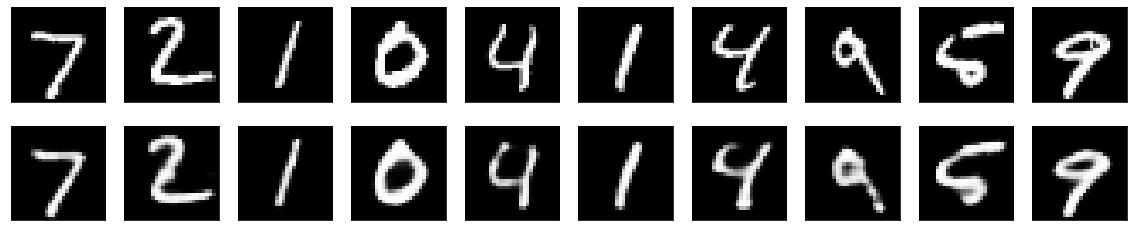

In [12]:
decoded_imgs = autoencoder.predict(x_test)
plot_figures(x_test, decoded_imgs)

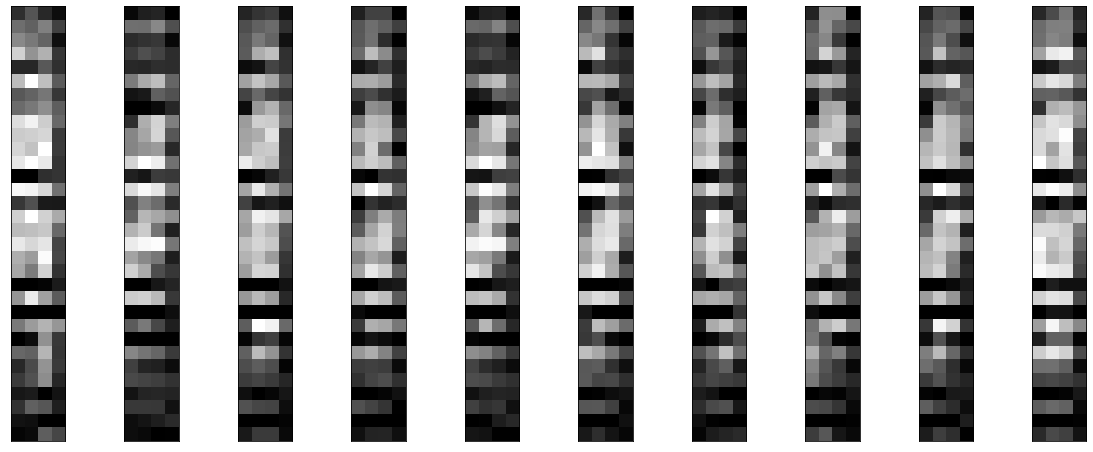

In [13]:
encoded_imgs = autoencoder.encoder.predict(x_test)
plot_encoded(encoded_imgs)